Mesh Size: 16, Error = N/A, Order of Convergence = N/A
Mesh Size: 32, Error = 0.3176, Order of Convergence = N/A
Mesh Size: 64, Error = 0.1680, Order of Convergence = 0.9185
Mesh Size: 128, Error = 0.0858, Order of Convergence = 0.9695
Mesh Size: 256, Error = 0.0433, Order of Convergence = 0.9880
Mesh Size: 512, Error = 0.0217, Order of Convergence = 0.9961
Mesh Size: 1024, Error = 0.0108, Order of Convergence = 0.9995


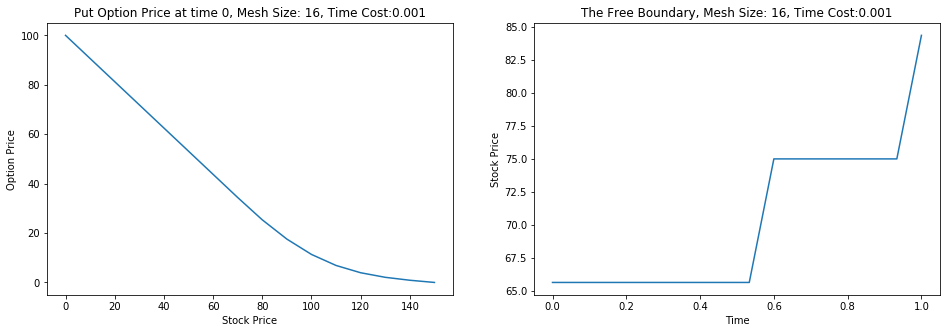

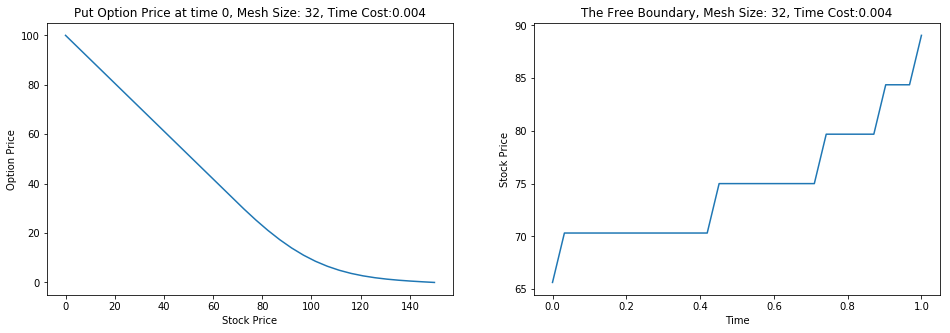

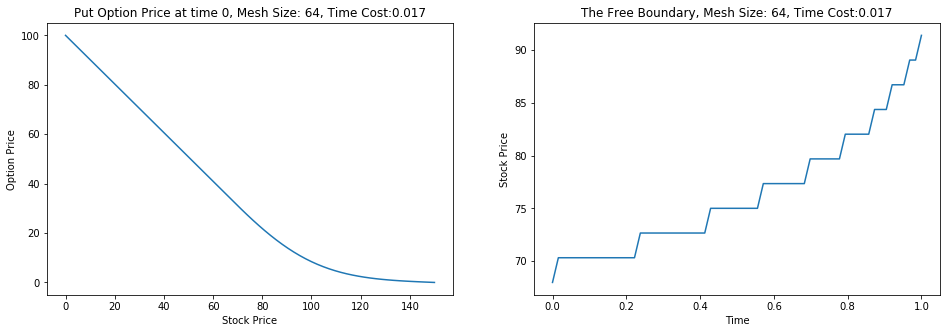

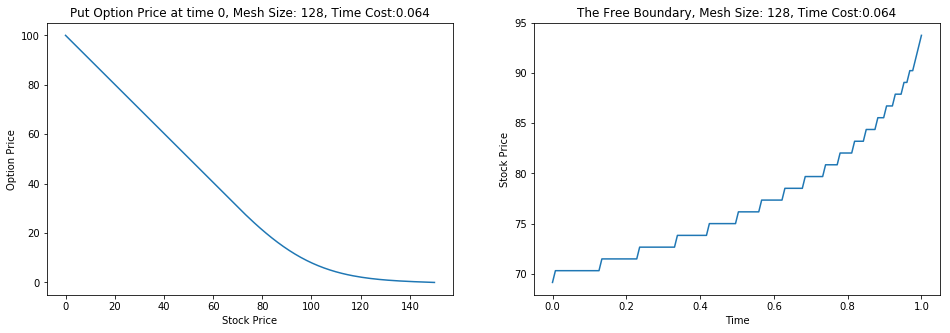

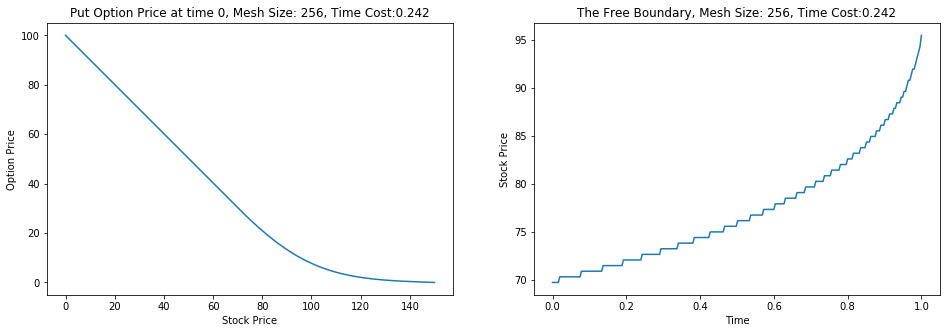

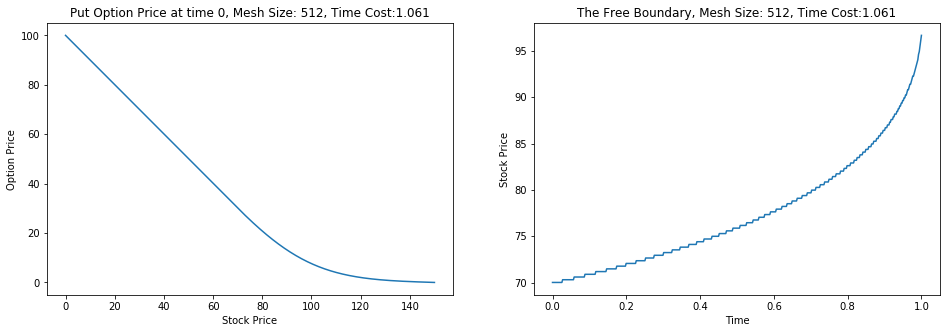

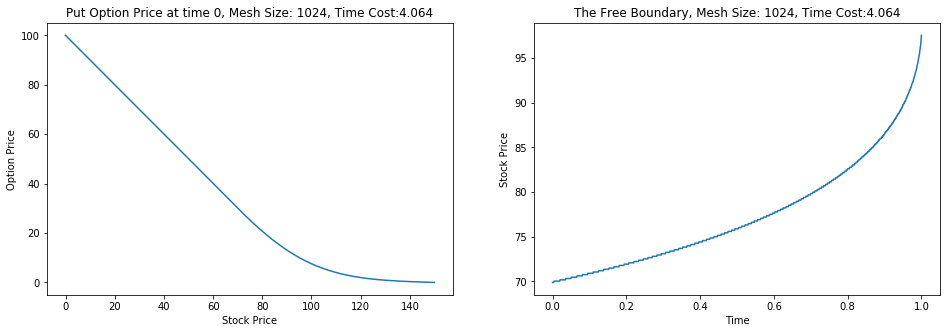

In [3]:
# -*- coding: utf-8 -*-
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


## Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
            
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc


def FDM_implicit(r, sigma, K, T, Smax, Nt, Nx):
    t = time.time()
    
    dt = 1/Nt
    dx = Smax/Nx

    "initialize U"
    U = [[0]] * (Nt+1)

    "create the matrix A using diagonal matrix"
    a = []
    b = []
    c = []
    u = []
    for i in range(1,Nx):
        a.append(-0.5*sigma*sigma*i*i*dt)
        b.append(1 + (r + r*i + sigma*sigma*i*i)*dt)
        c.append((-r*i - sigma*sigma*i*i/2)*dt)
        u.append(max(K-(i-1)*dx,0))
    
    a = a[1:]
    c = c[:-1]
    u = np.array(u)
    U[Nt] = np.concatenate((u, [0]))

    "solve the equation"
    boundary = np.zeros([Nt])
    
    for j in range(Nt-1,-1,-1):
        B = u
        B[0] = B[0] - (-0.5*sigma*sigma*dt)*K*np.exp(-r * (T - j*dt))
        #    u = spsolve(A, B)
        #    u = solve_banded((1,1),ab,B)
        u = TDMAsolver(a, b, c, B)
        for k in range(Nx-1):
            if u[k] < K-k*dx:
                u[k] = K-k*dx
                boundary[j]=(K-k*dx)                
                U[j] = np.concatenate((u, [0]))
                
    time_cost = time.time() - t
    X = np.linspace(0.0, Smax, Nx)
    Y = np.linspace(0.0, T, Nt)
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(X, U[0])
    plt.xlabel('Stock Price')
    plt.ylabel("Option Price")
    plt.title('Put Option Price at time 0, Mesh Size: %d, Time Cost:%.3f'%(Nt, time_cost))
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(Y, K - boundary)
    plt.xlabel('Time')
    plt.ylabel("Stock Price")
    plt.title('The Free Boundary, Mesh Size: %d, Time Cost:%.3f'%(Nt, time_cost))
    
    
    return U[0]

    
r = 0.01
sigma = 0.2
K = 100
T = 1
Smax = 150

Price = []

mesh = pow(2, np.array(range(4, 11)))

for m in mesh:
    Nt = Nx = m
    Price.append(FDM_implicit(r, sigma, K, T, Smax, Nt, Nx))

error = []
for m in range(len(Price)-1):
    error_tmp = []
    for n in range(len(Price[m])):
        error_tmp.append(abs(Price[m][n] - Price[m+1][2*n]))
    error.append(max(error_tmp))


converge_order=[]
for p in range(len(error)-1):
    converge_order.append(-np.log(error[p+1]/error[p])/np.log(2))


for q in range(len(mesh)):
    if q==0:
        print("Mesh Size: %d, Error = N/A, Order of Convergence = N/A" % (mesh[q]))
    elif q==1:
        print("Mesh Size: %d, Error = %.4f, Order of Convergence = N/A" % (mesh[q],error[q-1]))
    else:
        print("Mesh Size: %d, Error = %.4f, Order of Convergence = %.4f" % (mesh[q],error[q-1],converge_order[q-2]))
            



